In [934]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from pathlib import Path
from HelperClass.DataReader_1_3 import *
from HelperClass.HyperParameters_1_1 import *
from HelperClass.TrainingHistory_1_0 import *
from HelperClass.ClassifierFunction_1_1 import *

In [935]:
iris = pd.read_csv("Iris.csv")
iris.head() # 数据表

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


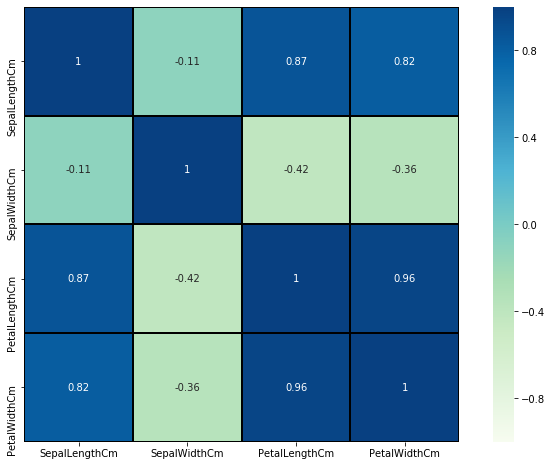

In [936]:
fig = plt.gcf()
fig.set_size_inches(12, 8)
fig = sns.heatmap(iris.corr(), annot=True, cmap='GnBu', linewidths=1, linecolor='k', square=True, mask=False, vmin=-1, vmax=1, cbar_kws={"orientation": "vertical"}, cbar=True)
# 绘制出4个特征值之间的相关性

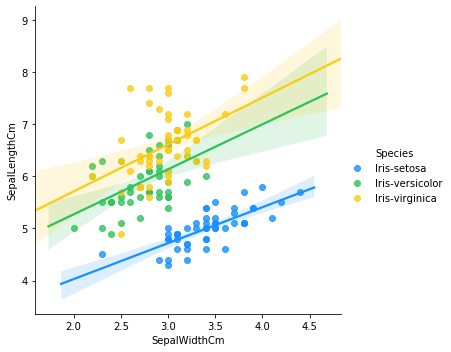

In [937]:
# 可以看到，PetalLength与PetalWidth的相关性最高
colors = ['#1890FF', '#2FC25B', '#FACC14', '#223273', '#8543E0', '#13C2C2', '#3436c7', '#F04864']
SepalPrograming = sns.lmplot(data=iris, x='SepalWidthCm', y='SepalLengthCm', palette=colors, hue='Species')

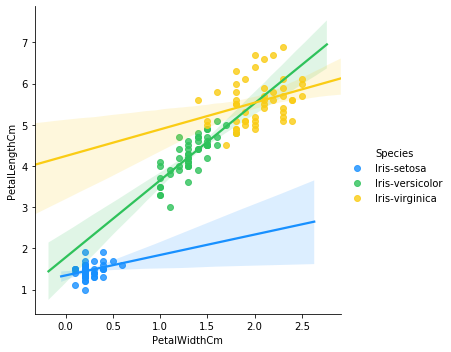

In [938]:
PetalPrograming = sns.lmplot(data=iris, x='PetalWidthCm', y='PetalLengthCm', palette=colors, hue='Species')

In [939]:
# 结合上面三张图可以看出，Petal的长宽发生变化时，对品种的影响最为显著
# 因此以下对相关性小的,即Setal的长宽进行分析
datalist = iris.values.tolist()

In [940]:
irisdata = iris.iloc[:,0:2].values.tolist()

In [941]:
irislabel = iris.iloc[:,4:5].values.tolist()

In [942]:
for x in range(len(irislabel)):
    if irislabel[x][0] == 'Iris-setosa':
        irislabel[x][0] = 1
    elif irislabel[x][0] == 'Iris-versicolor':
        irislabel[x][0] = 2
    else:
        irislabel[x][0] = 3

In [943]:
irisDict = {'data': irisdata, 'label': irislabel}
# irisSeries = pd.Series(irisDict)
# irisArray = irisSeries.values
np.savez('./irisdata', data = irisDict['data'], label = irisDict['label'])

In [944]:
class DataReader(object):
    def __init__(self, data_file):
        self.train_file_name = data_file
        self.num_train = 0
        self.XTrain = None  # normalized x, if not normalized, same as YRaw
        self.YTrain = None  # normalized y, if not normalized, same as YRaw
        self.XRaw = None    # raw x
        self.YRaw = None    # raw y

    # read data from file
    def ReadData(self):
        train_file = Path(self.train_file_name)
        if train_file.exists():
            data = np.load(self.train_file_name)
            self.XRaw = data["data"]
            # print(self.XRaw)
            self.YRaw = data["label"]
            # print(self.YRaw)
            self.num_train = self.XRaw.shape[0]
            self.XTrain = self.XRaw
            self.YTrain = self.YRaw
        else:
            raise Exception("Cannot find train file!!!")
        #end if

    # normalize data by extracting range from source data
    # return: X_new: normalized data with same shape
    # return: X_norm: N x 2
    #               [[min1, range1]
    #                [min2, range2]
    #                [min3, range3]]
    def NormalizeX(self):
        X_new = np.zeros(self.XRaw.shape)
        num_feature = self.XRaw.shape[1]
        self.X_norm = np.zeros((num_feature,2))
        # 按列归一化,即所有样本的同一特征值分别做归一化
        for i in range(num_feature):
            # get one feature from all examples
            col_i = self.XRaw[:,i]
            max_value = np.max(col_i)
            min_value = np.min(col_i)
            # min value
            self.X_norm[i,0] = min_value 
            # range value
            self.X_norm[i,1] = max_value - min_value 
            new_col = (col_i - self.X_norm[i,0])/(self.X_norm[i,1])
            X_new[:,i] = new_col
        #end for
        self.XTrain = X_new

    # normalize data by self range and min_value
    def NormalizePredicateData(self, X_raw):
        X_new = np.zeros(X_raw.shape)
        n = X_raw.shape[1]
        for i in range(n):
            col_i = X_raw[:,i]
            X_new[:,i] = (col_i - self.X_norm[i,0]) / self.X_norm[i,1]
        return X_new

    def NormalizeY(self):
        self.Y_norm = np.zeros((1,2))
        max_value = np.max(self.YRaw)
        min_value = np.min(self.YRaw)
        # min value
        self.Y_norm[0, 0] = min_value 
        # range value
        self.Y_norm[0, 1] = max_value - min_value 
        y_new = (self.YRaw - min_value) / self.Y_norm[0, 1]
        self.YTrain = y_new

    def ToOneHot(self, num_category, base=0):
        count = self.YRaw.shape[0]
        self.num_category = num_category
        y_new = np.zeros((count, self.num_category))
        # print(y_new)
        for i in range(count):
            n = (int)(self.YRaw[i,0])
            y_new[i,n-base] = 1
        self.YTrain = y_new

    # get batch training data
    def GetSingleTrainSample(self, iteration):
        x = self.XTrain[iteration]
        y = self.YTrain[iteration]
        return x, y

    # get batch training data
    def GetBatchTrainSamples(self, batch_size, iteration):
        start = iteration * batch_size
        end = start + batch_size
        batch_X = self.XTrain[start:end,:]
        batch_Y = self.YTrain[start:end,:]
        return batch_X, batch_Y

    def GetWholeTrainSamples(self):
        return self.XTrain, self.YTrain


    # permutation only affect along the first axis, so we need transpose the array first
    # see the comment of this class to understand the data format
    def Shuffle(self):
        seed = np.random.randint(0,100)
        np.random.seed(seed)
        XP = np.random.permutation(self.XTrain)
        np.random.seed(seed)
        YP = np.random.permutation(self.YTrain)
        self.XTrain = XP
        self.YTrain = YP


In [945]:
class NeuralNet_1_2(object):
    def __init__(self, params):
        self.params = params
        self.W = np.zeros((self.params.input_size, self.params.output_size))
        self.B = np.zeros((1, self.params.output_size))

    def forwardBatch(self, batch_x):
        Z = np.dot(batch_x, self.W) + self.B
        if self.params.net_type == NetType.BinaryClassifier:
            A = Logistic().forward(Z)
            return A
        elif self.params.net_type == NetType.MultipleClassifier:
            A = Softmax().forward(Z)
            return A
        else:
            return Z

    def backwardBatch(self, batch_x, batch_y, batch_a):
        m = batch_x.shape[0]
        dZ = batch_a - batch_y
        dB = dZ.sum(axis=0, keepdims=True)/m
        dW = np.dot(batch_x.T, dZ)/m
        return dW, dB

    def update(self, dW, dB):
        self.W = self.W - self.params.eta * dW
        self.B = self.B - self.params.eta * dB

    def inference(self, x):
        return self.forwardBatch(x)

    def train(self, dataReader, checkpoint=0.1):
        # calculate loss to decide the stop condition
        loss_history = TrainingHistory_1_0()
        loss_function = LossFunction_1_1(self.params.net_type)
        loss = 10
        if self.params.batch_size == -1:
            self.params.batch_size = dataReader.num_train
        max_iteration = math.ceil(dataReader.num_train / self.params.batch_size)
        checkpoint_iteration = (int)(max_iteration * checkpoint)

        for epoch in range(self.params.max_epoch):
#             print("epoch=%d" %epoch)
            dataReader.Shuffle()
            for iteration in range(max_iteration):
                # get x and y value for one sample
                batch_x, batch_y = dataReader.GetBatchTrainSamples(self.params.batch_size, iteration)
                # get z from x,y
                batch_a = self.forwardBatch(batch_x)
                # calculate gradient of w and b
                dW, dB = self.backwardBatch(batch_x, batch_y, batch_a)
                # update w,b
                self.update(dW, dB)

                total_iteration = epoch * max_iteration + iteration
                if (total_iteration+1) % checkpoint_iteration == 0:
                    loss = self.checkLoss(loss_function, dataReader)
#                     print(epoch, total_iteration, loss)
                    loss_history.AddLossHistory(epoch*max_iteration+iteration, loss)
                    if loss < self.params.eps:
                        break
                    #end if
                #end if
            # end for
            if loss < self.params.eps:
                break
        # end for
        loss_history.ShowLossHistory(self.params)
        print("W=", self.W)
        print("B=", self.B)


    def checkLoss(self, loss_fun, dataReader):
        X,Y = dataReader.GetWholeTrainSamples()
        m = X.shape[0]
        A = self.forwardBatch(X)
        loss = loss_fun.CheckLoss(A, Y)
        return loss


In [946]:
class LossFunction_1_1(object):
    def __init__(self, net_type):
        self.net_type = net_type
    # end def

    # fcFunc: feed forward calculation
    def CheckLoss(self, A, Y):
        m = Y.shape[0]
        if self.net_type == 1:
            loss = self.MSE(A, Y, m)
        elif self.net_type == 2:
            loss = self.CE2(A, Y, m)
        elif self.net_type == 3:
            loss = self.CE3(A, Y, m)
        #end if
        # print loss
        return loss
    # end def

    def MSE(self, A, Y, count):
        p1 = A - Y
        LOSS = np.multiply(p1, p1)
        loss = LOSS.sum()/count/2
        return loss
    # end def

    # for binary classifier
    def CE2(self, A, Y, count):
        p1 = 1 - Y
        p2 = np.log(1 - A)
        p3 = np.log(A)

        p4 = np.multiply(p1 ,p2)
        p5 = np.multiply(Y, p3)

        LOSS = np.sum(-(p4 + p5))  #binary classification
        loss = LOSS / count
        return loss
    # end def

    # for multiple classifier
    def CE3(self, A, Y, count):
        p1 = np.log(A)
        p2 =  np.multiply(Y, p1)
        LOSS = np.sum(-p2) 
        loss = LOSS / count
        return loss
    # end def


In [947]:
def ShowResult(X,Y,xt,yt):
    fig = plt.figure(figsize=(6,6))
    DrawThreeCategoryPoints(X[:,0], X[:,1], Y[:], xlabel="x1", ylabel="x2", show=False)

    b13 = (net.B[0,0] - net.B[0,2])/(net.W[1,2] - net.W[1,0])
    w13 = (net.W[0,0] - net.W[0,2])/(net.W[1,2] - net.W[1,0])

    b23 = (net.B[0,2] - net.B[0,1])/(net.W[1,1] - net.W[1,2])
    w23 = (net.W[0,2] - net.W[0,1])/(net.W[1,1] - net.W[1,2])

    b12 = (net.B[0,1] - net.B[0,0])/(net.W[1,0] - net.W[1,1])
    w12 = (net.W[0,1] - net.W[0,0])/(net.W[1,0] - net.W[1,1])

    x1 = (b23-b13)/(w13-w23)
    
    x = np.linspace(x1,1,2)
    y = w13 * x + b13
    p13, = plt.plot(x,y,c='r')

    x = np.linspace(x1,1,2)
    y = w23 * x + b23
    p23, = plt.plot(x,y,c='b')

    x = np.linspace(0,x1,2)
    y = w12 * x + b12
    p12, = plt.plot(x,y,c='g')    
    
    plt.legend([p13,p23,p12], ["13","23","12"])
    plt.axis([-0.1,1.1,-0.1,1.1])

    DrawThreeCategoryPoints(xt[:,0], xt[:,1], yt[:], xlabel="SepalLengthCm", ylabel="SepalWidthCm", show=True, isPredicate=True)

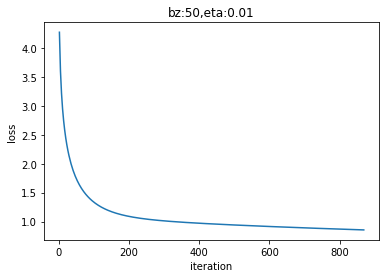

W= [[-0.44176115  0.15800664  0.51442569]
 [ 0.48227963 -0.17753196 -0.03107144]]
B= [[0.3047884  0.33284356 0.13726339]]
[[0.41984024 0.28959542 0.22434417]
 [0.29712881 0.33348616 0.36724019]
 [0.07394246 0.41436272 0.51660944]]


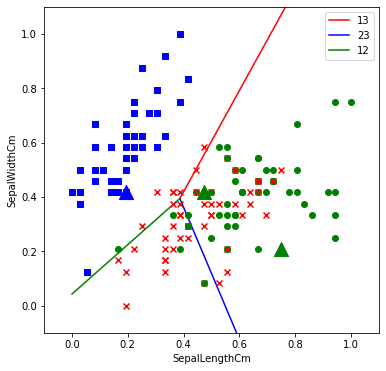

In [948]:
if __name__ == '__main__':
    num_category = 3
    reader = DataReader('irisdata.npz')
    reader.ReadData()
    reader.NormalizeX()
    reader.ToOneHot(num_category, base=1)
    
#     # 1 and 23 to classify 3个1对1二分类分类器之一的尝试
#     reader1 = DR.DataReader_1_0('irisdata.npz')
#     reader1.ReadData()
#     for x in range(len(reader1.YTrain)):
#         if reader1.YTrain[x][0]==1:
#             continue
#         else:
#             reader1.YTrain[x][0]=0
            
#     num_input = 2
#     params = HyperParameters(num_input, 2, eta=0.1, max_epoch=100, batch_size=10, eps=1e-3, net_type=2)
#     net = NET.NeuralNet_1_0(params)
#     net.train(reader)
    
    num_input = 2
    params = HyperParameters(num_input, num_category, eta=0.01, max_epoch=290, batch_size=50, eps=1e-3, net_type=3)
    net = NeuralNet_1_2(params)
    net.train(reader, checkpoint=1)
    xt_raw = np.array([5,3,6,3,7,2.5]).reshape(3,2)
    xt = reader.NormalizePredicateData(xt_raw)
    output = net.inference(xt)
    print(output)

    ShowResult(reader.XTrain, reader.YTrain, xt, output)
